# Credit Card Fraud Detection

The raw file used for this project is on kaggle, click <a href="https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud">here</a> to go to the file location on kaggle.

## IMPORTS

In [112]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import warnings
warnings.simplefilter(action="ignore")
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC

## Exploratory Data Analysis

In [3]:
with ZipFile("./creditcard.zip") as myzip:
    with myzip.open('creditcard.csv', "r") as myfile:
        df = pd.read_csv(myfile)

data = df.copy()
print(f"Shape of the data: {data.shape}")
data.drop_duplicates(inplace=True)
print(f"Shape of the data after dropping duplicate rows: {data.shape}")
data.head()

Shape of the data: (284807, 31)
Shape of the data after dropping duplicate rows: (283726, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# data.info()

In [4]:
data.isna().sum().sum()

0

Two things could be deduced from the investigations made above:
<ol><li>All the columns of the data are numeric values</li><li>There is/are no null values in the data.</li></ol>
It seems someone someone has done the <b>dirty</b> job for us to have a <b>clean</b> data. 😄

In [5]:
data["Class"].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

In [6]:
data["Class"].value_counts(normalize=True)

Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64

In [7]:
# Check Class variables that have 0 value for Genuine transactions and 1 for Fraud

# fig, ax = plt.subplots(1, 1)
# ax.pie(data.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','red'], startangle=90)
# plt.axis('equal')
# plt.xlabel('\nClass as pie chart', size=14)
# plt.title(f"Genuine: {data['Class'].value_counts().iloc[0]:,}\nFraud: {data['Class'].value_counts().iloc[1]:,}\n", size=12)
# plt.show()

In [8]:
# data["Time_Hr"] = data["Time"]/3600 # convert to hours
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(10,6))
# ax1.hist(data.Time_Hr[data.Class==0],bins=48,color='g',alpha=0.5)
# ax1.set_title('Genuine')
# ax2.hist(data.Time_Hr[data.Class==1],bins=48,color='r',alpha=0.5)
# ax2.set_title('Fraud')
# plt.xlabel('Time (hrs)')
# plt.ylabel('# Transactions')
# plt.show()

In [9]:
# fig, axs = plt.subplots(2, 1, figsize=(16, 9))
# axs = axs.ravel()
# sns.kdeplot(data[data["Class"] == 0]["Time_Hr"], fill=True, ax=axs[0], color="g", label="Genuine")
# sns.kdeplot(data[data["Class"] == 1]["Time_Hr"], fill=True, ax=axs[1], color="r", label="Fraud")
# axs[0].set_title("Distribution of Genuine and Fraudulent Card Transactions\n")
# plt.show()

In [10]:
#let us check another feature Amount

# fig, (ax3,ax4) = plt.subplots(2, 1, figsize = (10,6), sharex = True)
# ax3.hist(data.Amount[data.Class==0], bins=50,color='g', alpha=0.5)
# ax3.set_yscale('log') # to see the tails
# ax3.set_title('Genuine') # to see the tails
# ax3.set_ylabel('# transactions')
# ax4.hist(data.Amount[data.Class==1],bins=50,color='r',alpha=0.5)
# ax4.set_yscale('log') # to see the tails
# ax4.set_title('Fraud') # to see the tails
# ax4.set_xlabel('Amount ($)')
# ax4.set_ylabel('# transactions')
# plt.show() 

In [7]:
df = data.copy()

In [12]:
#let us check correlations and shapes of those 28 principal components.
# Features V1, V2, ... V28 are the principal components obtained with PCA.

# import seaborn as sns
# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(28, 1)
# plt.figure(figsize=(10, 28*4))
# data = data.replace([np.inf, -np.inf], np.nan)
# for i, col in enumerate(data[data.iloc[:, 0:28].columns]):
#     ax5 = plt.subplot(gs[i])
#     sns.kdeplot(data[col][data.Class == 1], color='r', label="Fraud", fill=True, multiple="stack")
#     sns.kdeplot(data[col][data.Class == 0], color='g', label="Genuine", fill=True)
#     ax5.set_xlabel('')
#     plt.legend()
#     ax5.set_title('feature: ' + str(col))
# plt.show()

## Feature Selection

In [4]:
# drop_list = ['Time_Hr', 'V13' ,'V15', 'V22', 'V23', 'V25', 'V26', 'Time']
drop_list = ['V13' ,'V15', 'V22', 'V23', 'V25', 'V26', 'Time']

In [8]:
# A function to remove columns that might not be useful for prediction

def split_data(df, drop_list=None, test_size=0.3, stratify=True):
    if drop_list:
        df=df.drop(drop_list, axis=1)
    X=df.drop(['Class'], axis=1) 
    Y=df["Class"] 
    xData = X.values
    yData = Y.values
    xTrain, xTest, yTrain, yTest = train_test_split( 
            xData, yData, test_size=test_size, random_state=42, stratify=None if not stratify else yData)
    return xTrain, xTest, yTrain, yTest

In [9]:
# No Resampling
# X_train_drop, X_test_drop, y_train_drop, y_test_drop = split_data(data, drop_list)
X_train, X_test, y_train, y_test = split_data(data)

# SMOTE Resampling
# smote = SMOTE(random_state=42)
# X_train_drop_smote, y_train_drop_smote = smote.fit_resample(X_train_drop, y_train_drop)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# ADASYN Resampling
# ada = ADASYN(random_state=42)
# X_train_drop_adasyn, y_train_drop_adasyn = smote.fit_resample(X_train_drop, y_train_drop)
# X_train_adasyn, y_train_adasyn = smote.fit_resample(X_train, y_train)

# SMOTETomek
# smotetomek = SMOTETomek(random_state=42, smote=SMOTE(random_state=42))
# X_train_drop_smotetomek, y_train_drop_smotetomek = smotetomek.fit_resample(X_train_drop, y_train_drop)
# X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train, y_train)

# SMOTEENN
# smoteenn = SMOTEENN(random_state=42)
# X_train_drop_smoteenn, y_train_drop_smoteenn = smoteenn.fit_resample(X_train_drop, y_train_drop)
# X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [65]:
# (X_train_drop_smotetomek.shape, y_train_drop_smotetomek.shape), (X_train_smotetomek.shape, y_train_smotetomek.shape)

(((454902, 23), (454902,)), ((453636, 30), (453636,)))

In [66]:
# (X_train_drop_smoteenn.shape, y_train_drop_smoteenn.shape), (X_train_smoteenn.shape, y_train_smoteenn.shape)

(((454138, 23), (454138,)), ((427652, 30), (427652,)))

In [10]:
X_train.shape, X_test.shape

((198608, 30), (85118, 30))

## Utility Functions

In [12]:
df[["Class", "Amount"]].groupby("Class").mean()

,Amount
Class,
0,88.413575
1,123.871860


In [13]:
def money_lost(FP, FN):
    return (FP * 88.413575 + FN * 123.871860) * -1

## LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.70      0.73      0.71       142

    accuracy                           1.00     85118
   macro avg       0.85      0.87      0.86     85118
weighted avg       1.00      1.00      1.00     85118



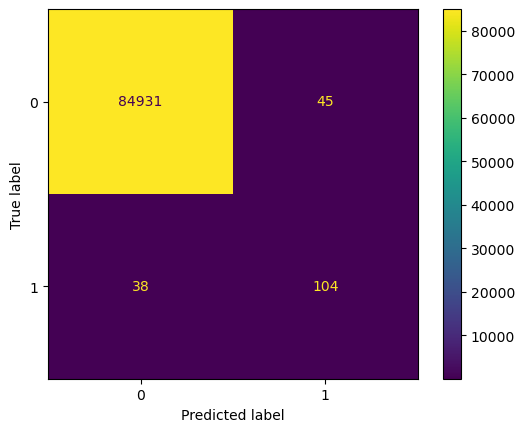

In [46]:
lr = LogisticRegression(class_weight={0:.4, 1:.6})
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

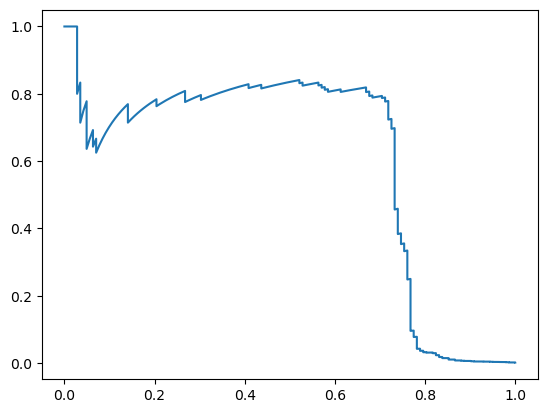

In [47]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr.predict_proba(X_test)[:, -1])
plt.plot(lr_recall, lr_precision);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.81      0.75      0.78       142

    accuracy                           1.00     85118
   macro avg       0.91      0.88      0.89     85118
weighted avg       1.00      1.00      1.00     85118



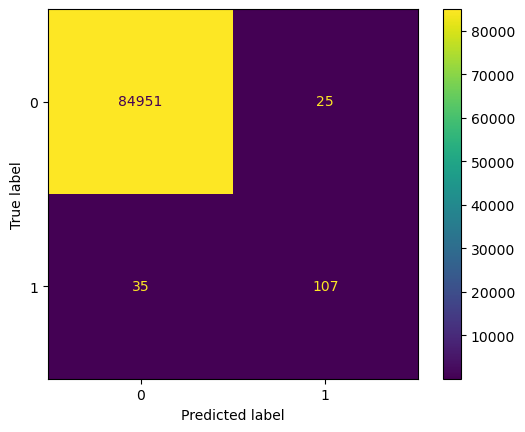

In [43]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(class_weight={0:.2, 1:.8}))
pipe_lr.fit(X_train, y_train)
y_pred, y_pred_prob = pipe_lr.predict(X_test), pipe_lr.predict_proba(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

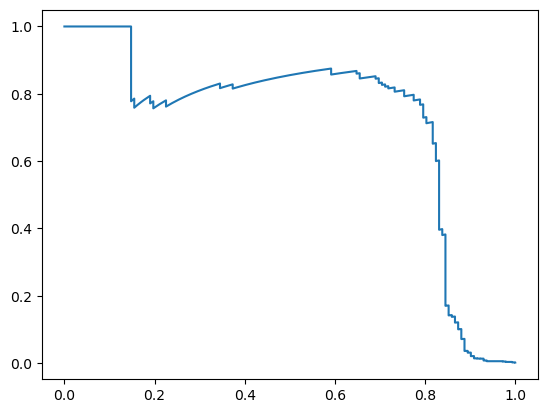

In [54]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, pipe_lr.predict_proba(X_test)[:, -1])
plt.plot(lr_recall, lr_precision);

## NAÏVE BAYES

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     84976
           1       0.14      0.63      0.23       142

    accuracy                           0.99     85118
   macro avg       0.57      0.81      0.61     85118
weighted avg       1.00      0.99      1.00     85118



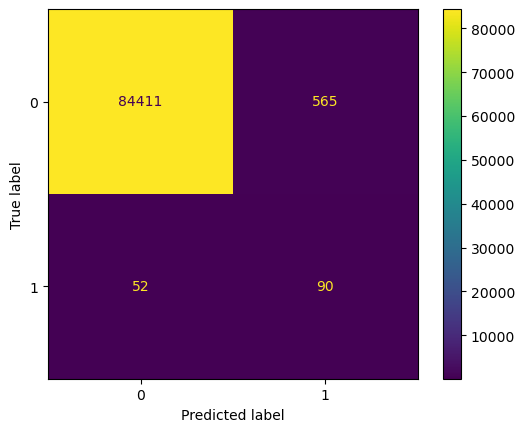

In [74]:
nb = GaussianNB()#priors=[.45, .55])
nb.fit(X_train, y_train)
y_pred, y_pred_prob = nb.predict(X_test), nb.predict_proba(X_test)[:, -1]
nb_precision, nb_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

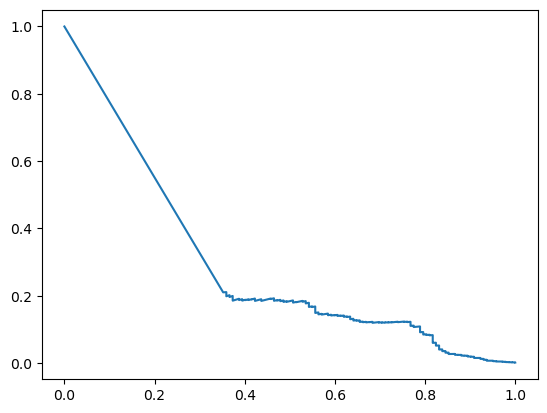

In [68]:
plt.plot(nb_recall, nb_precision);

In [69]:
nb.class_prior_

array([0.9983334, 0.0016666])

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     84976
           1       0.06      0.82      0.11       142

    accuracy                           0.98     85118
   macro avg       0.53      0.90      0.55     85118
weighted avg       1.00      0.98      0.99     85118



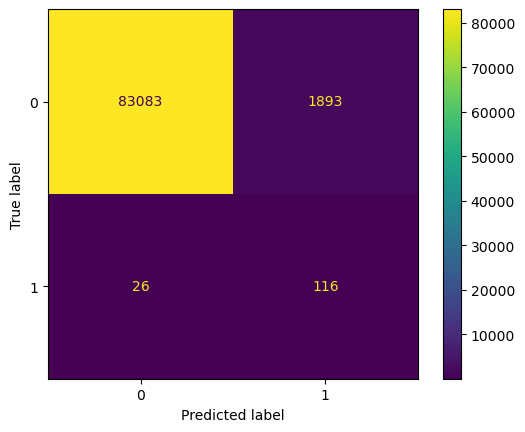

In [80]:
pipe_nb = make_pipeline(StandardScaler(), GaussianNB())
pipe_nb.fit(X_train, y_train)
y_pred, y_pred_prob = pipe_nb.predict(X_test), pipe_nb.predict_proba(X_test)[:, -1]
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

In [77]:
money_lost(1893, 26), money_lost(565, 52)

(-170587.565835, -56395.006595)

In [84]:
# SMOTE Resampling
smote = SMOTE(random_state=42)
X_train_smote = StandardScaler().fit_transform(X_train)
# X_train_drop_smote, y_train_drop_smote = smote.fit_resample(X_train_drop, y_train_drop)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     84976
           1       0.15      0.75      0.25       142

    accuracy                           0.99     85118
   macro avg       0.58      0.87      0.62     85118
weighted avg       1.00      0.99      1.00     85118



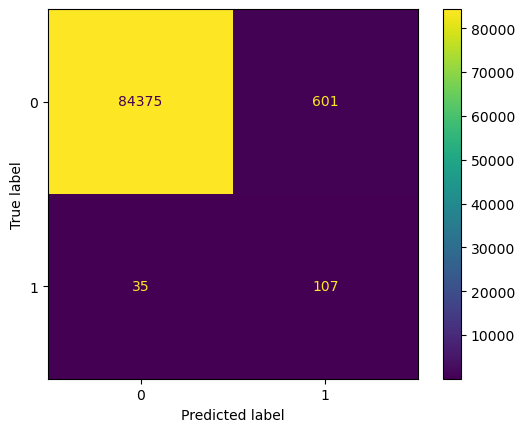

In [86]:
# pipe_nb = make_pipeline(StandardScaler(), GaussianNB())
pipe_nb = GaussianNB()
pipe_nb.fit(X_train_smote, y_train_smote)
y_pred, y_pred_prob = pipe_nb.predict(X_test), pipe_nb.predict_proba(X_test)[:, -1]
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

## XGBOOST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.75      0.84       142

    accuracy                           1.00     85118
   macro avg       0.98      0.87      0.92     85118
weighted avg       1.00      1.00      1.00     85118



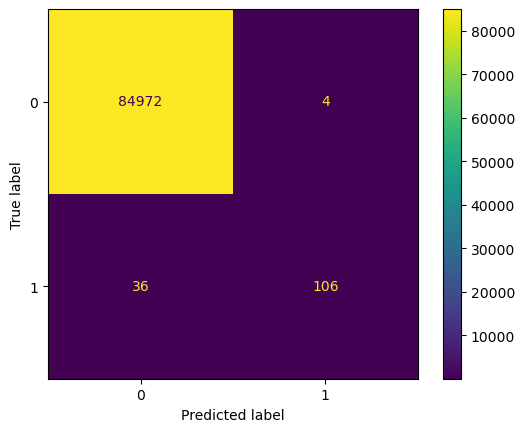

In [88]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred, y_pred_prob = xgb.predict(X_test), xgb.predict_proba(X_test)[:, -1]
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

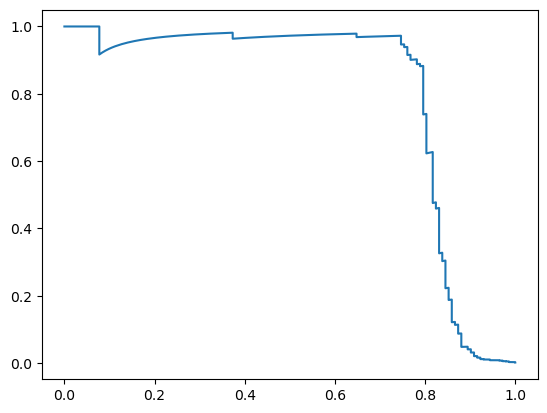

In [91]:
plt.plot(xgb_recall, xgb_precision);

## Decision Tree

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.77      0.71      0.74       142

    accuracy                           1.00     85118
   macro avg       0.89      0.86      0.87     85118
weighted avg       1.00      1.00      1.00     85118



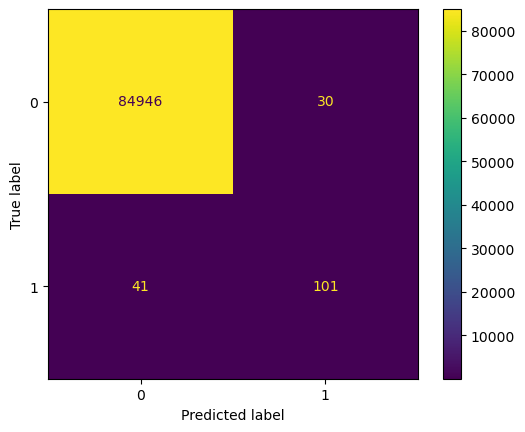

In [98]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y_pred, y_pred_proba = dtree.predict(X_test), dtree.predict_proba(X_test)[:, -1]
dtree_precision, dtree_recall, _ = precision_recall_curve(y_test, y_pred_proba)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

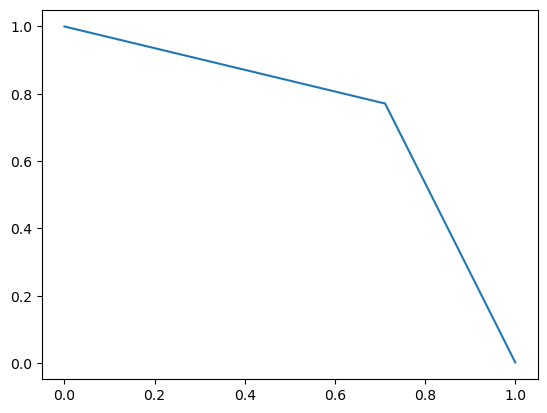

In [100]:
plt.plot(dtree_recall, dtree_precision);

checker
Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'sqrt'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.80      0.67      0.73       142

    accuracy                           1.00     85118
   macro avg       0.90      0.83      0.86     85118
weighted avg       1.00      1.00      1.00     85118



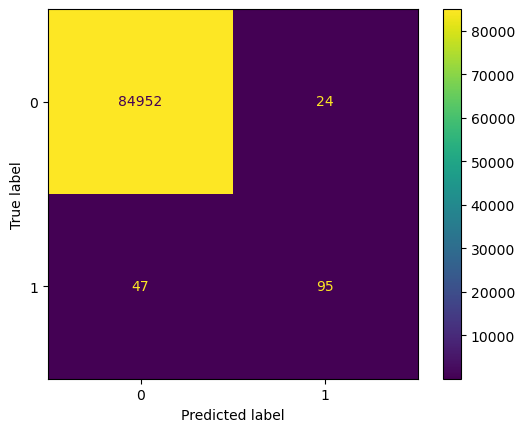

In [104]:
dtree_tuned = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={"criterion": ["gini", "entropy", "log_loss"], "ccp_alpha": np.linspace(0, 1, 5), "max_features": [None, "sqrt", "log2"]}, n_jobs=-1, verbose=3, scoring="f1")
print("checker")
dtree_tuned.fit(X_train, y_train)
print(dtree_tuned.best_params_)
y_pred, y_pred_prob = dtree_tuned.predict(X_test), dtree_tuned.predict_proba(X_test)[:, -1]
d_tree_precision, dtree_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_features': None}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.77      0.71      0.74       142

    accuracy                           1.00     85118
   macro avg       0.89      0.86      0.87     85118
weighted avg       1.00      1.00      1.00     85118



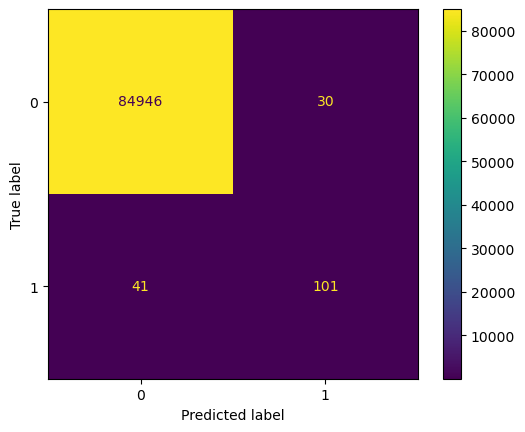

In [105]:
dtree_tuned = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={"criterion": ["gini", "entropy", "log_loss"], "ccp_alpha": np.linspace(0, 1, 5), "max_features": [None, "sqrt", "log2"]}, n_jobs=-1, verbose=3, scoring="recall")
# print("checker")
dtree_tuned.fit(X_train, y_train)
print(dtree_tuned.best_params_)
y_pred, y_pred_prob = dtree_tuned.predict(X_test), dtree_tuned.predict_proba(X_test)[:, -1]
d_tree_precision, dtree_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

Fitting 5 folds for each of 45 candidates, totalling 225 fits
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_features': 'sqrt'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.80      0.67      0.73       142

    accuracy                           1.00     85118
   macro avg       0.90      0.83      0.86     85118
weighted avg       1.00      1.00      1.00     85118



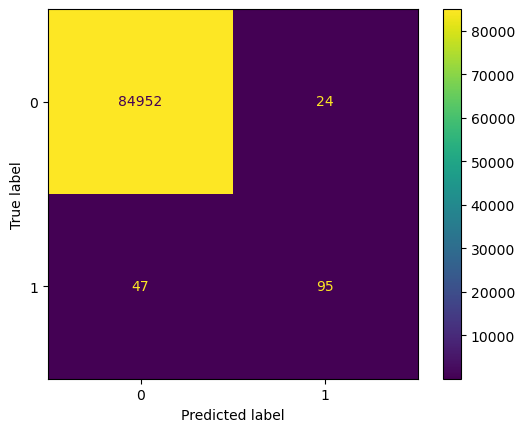

In [106]:
dtree_tuned = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={"criterion": ["gini", "entropy", "log_loss"], "ccp_alpha": np.linspace(0, 1, 5), "max_features": [None, "sqrt", "log2"]}, n_jobs=-1, verbose=3, scoring="accuracy")
# print("checker")
dtree_tuned.fit(X_train, y_train)
print(dtree_tuned.best_params_)
y_pred, y_pred_prob = dtree_tuned.predict(X_test), dtree_tuned.predict_proba(X_test)[:, -1]
d_tree_precision, dtree_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

## Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.78      0.86       142

    accuracy                           1.00     85118
   macro avg       0.98      0.89      0.93     85118
weighted avg       1.00      1.00      1.00     85118



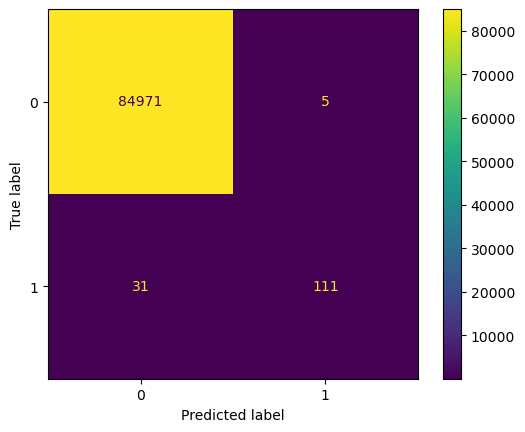

In [107]:
rcf = RandomForestClassifier(random_state=42)
rcf.fit(X_train, y_train)
y_pred, y_pred_prob = rcf.predict(X_test), rcf.predict_proba(X_test)[:, -1]
rcf_precision, rcf_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

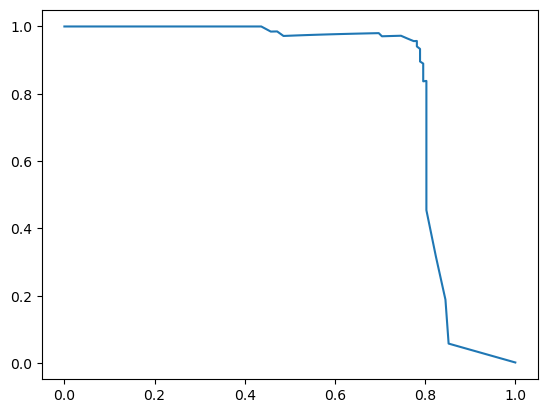

In [108]:
plt.plot(rcf_recall, rcf_precision);

In [111]:
rcf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid={})
rcf.fit(X_train, y_train)
y_pred, y_pred_prob = rcf.predict(X_test), rcf.predict_proba(X_test)[:, -1]
rcf_precision, rcf_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

array([0.01325688, 0.0132014 , 0.01621708, 0.01992715, 0.02951292,
       0.01133097, 0.01350576, 0.02453563, 0.01131013, 0.03247541,
       0.08292855, 0.0493452 , 0.12880457, 0.0098751 , 0.12584365,
       0.01161998, 0.07980318, 0.16047698, 0.03110857, 0.01230306,
       0.01610792, 0.01654704, 0.01185102, 0.00693735, 0.00951838,
       0.00711594, 0.0220283 , 0.01272218, 0.00915389, 0.01063581])

## SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.00      0.00      0.00       142

    accuracy                           1.00     85118
   macro avg       0.50      0.50      0.50     85118
weighted avg       1.00      1.00      1.00     85118



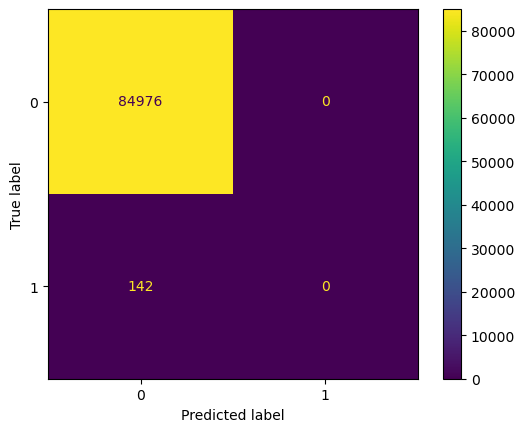

In [114]:
svm = SVC(random_state=42, probability=True)
svm.fit(X_train, y_train)
y_pred, y_pred_prob = svm.predict(X_test), svm.predict_proba(X_test)[:, -1]
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

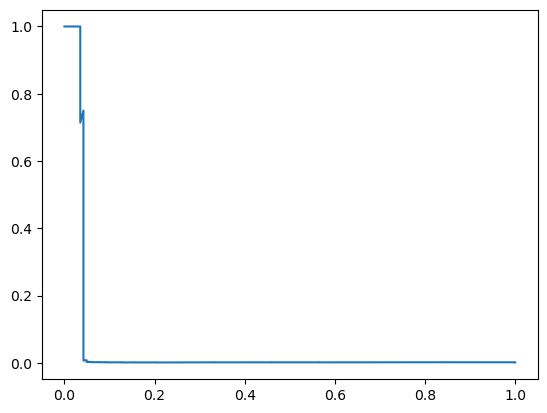

In [116]:
plt.plot(svm_recall, svm_precision);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.00      0.00      0.00       142

    accuracy                           1.00     85118
   macro avg       0.50      0.50      0.50     85118
weighted avg       1.00      1.00      1.00     85118



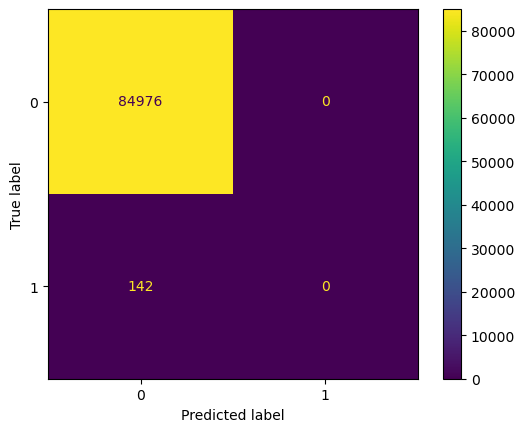

In [119]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred, y_pred_prob = svm.predict(X_test), svm.predict_proba(X_test)[:, -1]
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.00      0.00      0.00       142

    accuracy                           1.00     85118
   macro avg       0.50      0.50      0.50     85118
weighted avg       1.00      1.00      1.00     85118



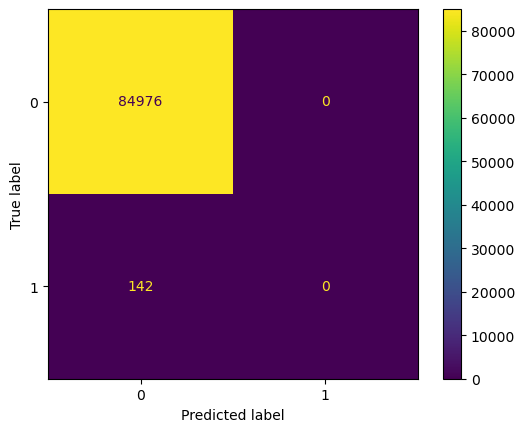

In [121]:
svm = SVC(probability=False)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
# svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.84      0.78      0.81       142

    accuracy                           1.00     85118
   macro avg       0.92      0.89      0.90     85118
weighted avg       1.00      1.00      1.00     85118



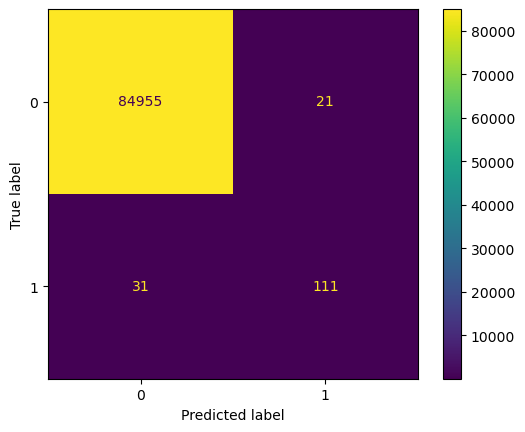

In [122]:
svm_pipe = make_pipeline(MinMaxScaler(feature_range=(-1, 1)), SVC(random_state=42, probability=True))
svm_pipe.fit(X_train, y_train)
y_pred, y_pred_prob = svm_pipe.predict(X_test), svm_pipe.predict_proba(X_test)[:, -1]
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_prob)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

## PCA

In [50]:
pca = PCA()
ss = StandardScaler()
ss_train = ss.fit_transform(X_train)
pca_train = pca.fit_transform(ss_train)

In [11]:
mm = MinMaxScaler(feature_range=(-1, 1))
mm_train = mm.fit_transform(X_train)
pca_train = pca.fit_transform(mm_train)

In [51]:
((pca.explained_variance_ratio_) * 100).round(2)

array([6.48, 5.64, 3.5 , 3.47, 3.44, 3.41, 3.4 , 3.39, 3.38, 3.37, 3.37,
       3.36, 3.36, 3.36, 3.35, 3.35, 3.34, 3.33, 3.33, 3.33, 3.32, 3.31,
       3.31, 3.3 , 3.23, 3.2 , 3.18, 2.98, 1.06, 0.14])

In [14]:
pca.score(mm_train)

46.65670717151833

In [39]:
# plt.figure(figsize = (11,6))
# components = [str(i) for i in range(1, 31)]
# var_exp = pca.explained_variance_ratio_
# plt.bar(components, var_exp)
# plt.title('Explained variance by principal components')
# plt.xlabel('Principal components')
# plt.ylabel('Explained variance ratio')
# plt.show()

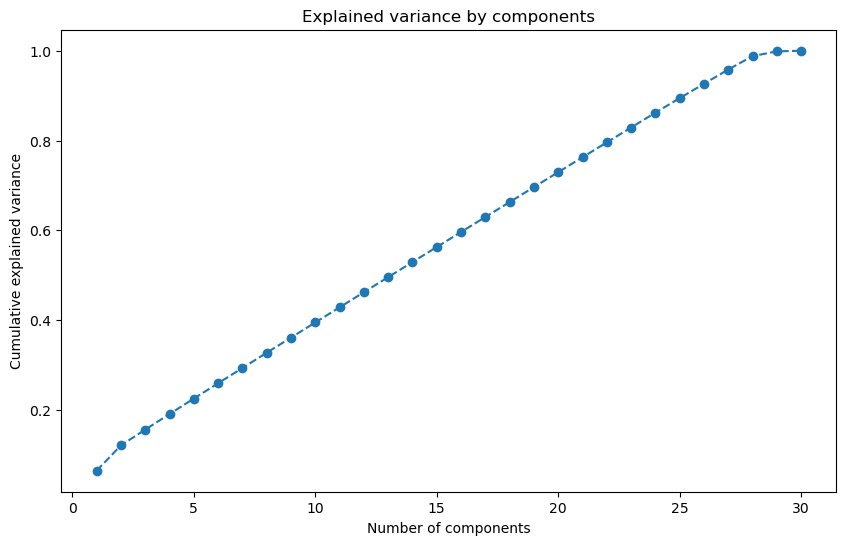

In [52]:
plt.figure(figsize=(10,6))
plt.plot(range(1,31),pca.explained_variance_ratio_.cumsum(),marker='o', linestyle='--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [53]:
pca.explained_variance_ratio_.cumsum()* 100

array([  6.48043515,  12.12364583,  15.62830183,  19.10084762,
        22.54152124,  25.94990672,  29.34889772,  32.74360526,
        36.12173083,  39.49166898,  42.86016523,  46.22280355,
        49.58233606,  52.93752684,  56.28387594,  59.62913505,
        62.96910263,  66.30079195,  69.63059544,  72.95600934,
        76.2779444 ,  79.59193822,  82.9032031 ,  86.20524779,
        89.43949664,  92.6404067 ,  95.8165127 ,  98.79863992,
        99.85610425, 100.        ])